In [5]:
import pandas as pd
import numpy as np
try:
    import cPickle as pickle
except:
    import pickle

In [2]:
beijing = pd.read_excel('.\\aqi7city.xlsx',header=None, sheet_name=0, names=['date','aqi','degree','pm25','pm10','so2','co','no2','o3_8h'])
shanghai = pd.read_excel('.\\aqi7city.xlsx',header=None,sheet_name=1, names=['date','aqi','degree','pm25','pm10','so2','co','no2','o3_8h'])
chengdu = pd.read_excel('.\\aqi7city.xlsx',header=None,sheet_name=2, names=['date','aqi','degree','pm25','pm10','so2','co','no2','o3_8h'])
wuhan = pd.read_excel('.\\aqi7city.xlsx',header=None,sheet_name=3, names=['date','aqi','degree','pm25','pm10','so2','co','no2','o3_8h'])
guangzhou = pd.read_excel('.\\aqi7city.xlsx',header=None,sheet_name=4, names=['date','aqi','degree','pm25','pm10','so2','co','no2','o3_8h'])
xian = pd.read_excel('.\\aqi7city.xlsx',header=None,sheet_name=5, names=['date','aqi','degree','pm25','pm10','so2','co','no2','o3_8h'])
nanjing = pd.read_excel('.\\aqi7city.xlsx',header=None,sheet_name=6, names=['date','aqi','degree','pm25','pm10','so2','co','no2','o3_8h'])


In [57]:
cities = ['beijing', 'shanghai', 'chengdu', 'wuhan', 'guangzhou', 'xian', 'nanjing']

In [44]:
nanjing.head()

,date,aqi,degree,pm25,pm10,so2,co,no2,o3_8h
0,2013-12-02,180,中度污染,136,253,87,2.0,120,25
1,2013-12-03,234,重度污染,184,297,108,2.5,133,17
2,2013-12-04,386,严重污染,336,455,51,2.5,130,43
3,2013-12-05,328,严重污染,278,386,52,2.3,110,59
4,2013-12-06,319,严重污染,269,389,61,2.2,92,36


In [3]:
timeStamps = nanjing.date.unique() #2280
len(timeStamps) 

2281

In [4]:
bj = beijing.drop(['date', 'degree'], axis=1)
sh = shanghai.drop(['date', 'degree'], axis=1)
cd = chengdu.drop(['date', 'degree'], axis=1)
wh = wuhan.drop(['date', 'degree'], axis=1)
gz = guangzhou.drop(['date', 'degree'], axis=1)
xa = xian.drop(['date', 'degree'], axis=1)
nj = nanjing.drop(['date', 'degree'], axis=1)

In [5]:
#join different cities
df_joint = pd.concat([bj,sh,cd,wh,gz,xa,nj], axis=1)
aqi2d = df_joint.values # dataframe to numpy array
aqi3d = aqi2d.reshape((aqi2d.shape[0],7,7)) # 2d to 3d

In [70]:
df_joint

,aqi,pm25,pm10,so2,co,no2,o3_8h,aqi,pm25,pm10,...,co,no2,o3_8h,aqi,pm25,pm10,so2,co,no2,o3_8h
0,142,109,138,61,2.6,88,11,267,217,252,...,3.2,77,17,180,136,253,87,2.0,120,25
1,86,64,86,38,1.6,54,45,200,150,152,...,2.1,50,31,234,184,297,108,2.5,133,17
2,109,82,101,42,2.0,62,23,158,121,140,...,2.2,52,25,386,336,455,51,2.5,130,43
3,56,39,56,30,1.2,38,52,288,238,251,...,1.9,48,34,328,278,386,52,2.3,110,59
4,169,128,162,48,2.5,78,15,468,452,472,...,2.3,67,26,319,269,389,61,2.2,92,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2276,70,51,75,10,0.9,26,68,65,47,52,...,1.4,49,128,95,71,91,9,1.1,40,45
2277,53,37,47,5,0.6,22,79,44,28,36,...,1.2,30,90,52,32,53,4,0.6,19,96
2278,40,28,32,4,0.5,24,56,47,29,44,...,0.9,21,34,54,30,57,6,0.6,28,91
2279,88,65,63,3,0.7,29,74,52,36,42,...,0.9,26,35,34,21,28,4,0.6,27,63


### normalization

In [88]:
aqi3d.shape

(2281, 7, 7)

In [89]:
aqi3d[:,:,0]

array([[142., 267., 265., ...,  77., 251., 180.],
       [ 86., 200., 269., ..., 149., 127., 234.],
       [109., 158., 285., ..., 134.,  90., 386.],
       ...,
       [ 40.,  47., 138., ...,  54.,  33.,  54.],
       [ 88.,  52.,  38., ...,  44.,  48.,  34.],
       [114.,  47.,  69., ...,  62.,  59.,  38.]])

In [6]:
def array_normalize(array):
    maxVal = np.amax(array)
    minVal = np.amin(array)
#     print(maxVal)
#     print(minVal)
    return (array - minVal) / (maxVal - minVal)

In [7]:
normAqi3d = np.zeros_like(aqi3d)
for i in range(aqi3d.shape[0]):
    normAqi3d[i,:,:] = array_normalize(aqi3d[i,:,:])

In [8]:
normAqi3d.shape

(2281, 7, 7)

### extract dataset seq2seq

In [12]:
from numpy import zeros, newaxis
def extract_dataset_seq2seq(frames,n_steps,lag):
    '''
    this fun get inputs from the output of extract_frame_new()
    frames: the proprocessed data in ndarray
    n_steps: length of RNN window
    lag: the time lag from x to y
    '''
    X, Y = list(), list()
    for i in range(len(frames)):
        end_ix = i + n_steps
        
        if end_ix > len(frames) - lag-1:
            break
        X_i, Y_i = frames[i:end_ix], frames[i+lag:end_ix+lag]
        X.append(X_i)
        Y.append(Y_i)
    XX = np.asarray(X)
    YY = np.asarray(Y)
    
    return XX[:,:,:,:,newaxis], YY[:,:,:,:,newaxis]

In [13]:
X, y = extract_dataset_seq2seq(normAqi3d,5,5)
with open('X7city.pkl', 'wb') as fp1:
    pickle.dump(X, fp1)

with open('y7city.pkl', 'wb') as fp2:
    pickle.dump(y, fp2)

## training

In [1]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


### seq2seq

In [2]:
seq = Sequential()
seq.add(ConvLSTM2D(filters=1, kernel_size=(2, 2),
                   input_shape=(None, 7, 7, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=1, kernel_size=(2, 2),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='mean_absolute_error', optimizer='sgd')
# seq.compile(loss='mean_squared_error', optimizer='sgd', metrics=['mae', 'acc'])

In [3]:
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 7, 7, 1)     36        
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 7, 7, 1)     4         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 7, 7, 1)     36        
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 7, 7, 1)     4         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, None, 7, 7, 1)     28        
Total params: 108
Trainable params: 104
Non-trainable params: 4
_________________________________________________________________


In [6]:
with open('X7city.pkl', 'rb') as file:
    X = pickle.load(file)
with open('y7city.pkl', 'rb') as file1:
    Y = pickle.load(file1)

In [7]:
X.shape

(2271, 5, 7, 7, 1)

In [8]:
Y.shape

(2271, 5, 7, 7, 1)

In [9]:
X_train = X[:2000]
Y_train = Y[:2000]

X_test = X[2000:2275]
Y_test = Y[2000:2275]

In [10]:
seq.fit(X_train, Y_train, batch_size=10, epochs=20, validation_split=0.05)

Train on 1900 samples, validate on 100 samples
Epoch 1/20
1900/1900 [==============================] - 14s 8ms/step - loss: 0.2650 - val_loss: 0.2270
Epoch 2/20
1900/1900 [==============================] - 10s 5ms/step - loss: 0.1882 - val_loss: 0.1635
Epoch 3/20
1900/1900 [==============================] - 10s 5ms/step - loss: 0.1528 - val_loss: 0.1440
Epoch 4/20
1900/1900 [==============================] - 10s 5ms/step - loss: 0.1448 - val_loss: 0.1374
Epoch 5/20
1900/1900 [==============================] - 10s 5ms/step - loss: 0.1408 - val_loss: 0.1330
Epoch 6/20
1900/1900 [==============================] - 10s 5ms/step - loss: 0.1377 - val_loss: 0.1297
Epoch 7/20
1900/1900 [==============================] - 10s 5ms/step - loss: 0.1352 - val_loss: 0.1272
Epoch 8/20
1900/1900 [==============================] - 10s 5ms/step - loss: 0.1331 - val_loss: 0.1253
Epoch 9/20
1900/1900 [==============================] - 10s 5ms/step - loss: 0.1317 - val_loss: 0.1239
Epoch 10/20
1900/1900 [===

# prediction

In [11]:
Y_hat = seq.predict(X_test, verbose=0)

In [14]:
Y_hat.shape

(271, 5, 7, 7, 1)

## visulization

In [ ]:
cities = ['beijing', 'shanghai', 'chengdu', 'wuhan', 'guangzhou', 'xian', 'nanjing']

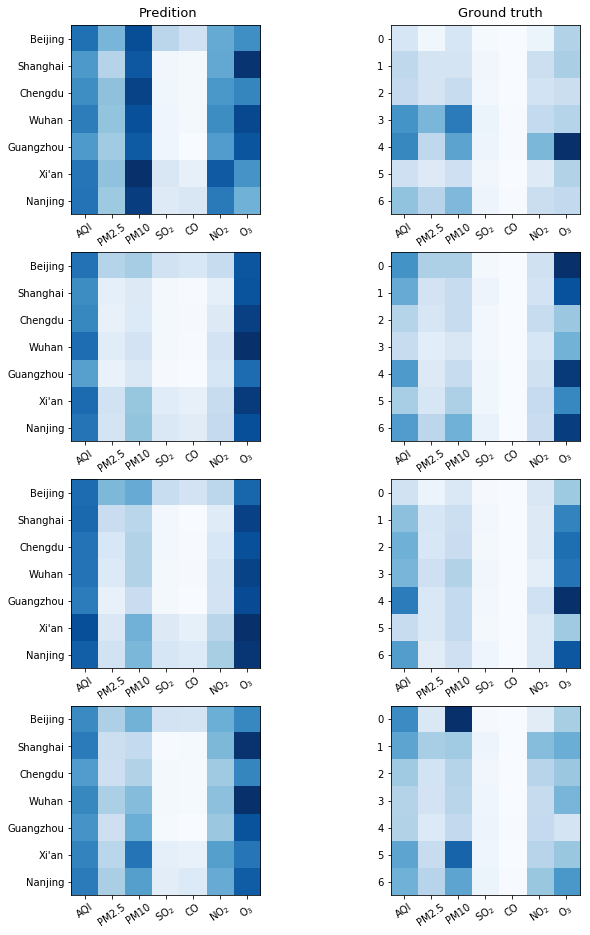

In [21]:
import random
length = Y_hat.shape[0]
import matplotlib.pyplot as plt
import numpy as np
random_ind = random.sample(range(0, length-1), 6)


y_pre_0 = Y_hat[random_ind[0],4,:,:,0]
y_pre_1 = Y_hat[random_ind[1],4,:,:,0]
y_pre_2 = Y_hat[random_ind[2],4,:,:,0]
y_pre_3 = Y_hat[random_ind[3],4,:,:,0]

y_truth_0 = Y_test[random_ind[0],4,:,:,0]
y_truth_1 = Y_test[random_ind[1],4,:,:,0]
y_truth_2 = Y_test[random_ind[2],4,:,:,0]
y_truth_3 = Y_test[random_ind[3],4,:,:,0]

stations = ['Beijing', 'Shanghai', 'Chengdu', 'Wuhan', 'Guangzhou', 'Xi\'an','Nanjing']
#     fea = ['co', 'no2', 'o3', 'pm10', 'pm2.5', 'so2', 'pressure', 'temperature', 'humidity']
fea = ['AQI','PM2.5','PM10',r'SO$_2$','CO', r'NO$_2$', r'O$_3$']

fig, (ax1, ax2)= plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10.5, 16))

# plt.yticks(np.arange(7), stations, fontsize=12)
# ax1.set_yticklabels(stations,fontsize=13,rotation=30)
# ax1.set_xticklabels(fea)
#         plt.xticks = [0, 1, 2,3,4,5,6,7,8]
# plt.setp(ax1, xticks = [0, 1, 2,3,4,5,6,7,8])
# plt.setp(ax2, yticks = [0, 1, 2,3,4,5,6])

xticks = [0, 1, 2,3,4,5,6]
yticks = [0, 1, 2,3,4,5,6]

# plt.setp(ax1.get_xticklabels(), rotation=40, ha="right", rotation_mode="anchor")
# plt.setp(ax2.get_xticklabels(), rotation=30)



plt.subplot(421,sharex=ax1)
plt.imshow(y_pre_0, cmap='Blues')
plt.text(2, -0.8, 'Predition', fontsize=13)
plt.setp(plt.gca(), yticks=yticks, yticklabels=stations)

plt.subplot(422, sharex=ax2)
plt.imshow(y_truth_0, cmap='Blues')
plt.text(2, -0.8, 'Ground truth', fontsize=13)

plt.subplot(423,sharex=ax1)
plt.imshow(y_pre_1,cmap='Blues')
plt.setp(plt.gca(), yticks=yticks, yticklabels=stations)

plt.subplot(424, sharex=ax2)
plt.imshow(y_truth_1,cmap='Blues')

plt.subplot(425, sharex=ax1)
plt.imshow(y_pre_2,cmap='Blues')
plt.setp(plt.gca(), yticks=yticks, yticklabels=stations)

plt.subplot(426, sharex=ax2)
plt.imshow(y_truth_2,cmap='Blues')

plt.subplot(427, sharex=ax1)
plt.imshow(y_pre_3,cmap='Blues')
plt.setp(plt.gca(), yticks=yticks, yticklabels=stations)
# plt.setp(plt.gca(), xticks=xticks, xticklabels=fea,
#          yticks=yticks, yticklabels=stations)

plt.subplot(428, sharex=ax2)
plt.imshow(y_truth_3,cmap='Blues')
plt.setp(plt.gca(), xticks=xticks, xticklabels=fea)
for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=35)


# cbar = fig.colorbar(im)
# cbar.solids.set_edgecolor("face")
plt.savefig('predict-map-7city.png', dpi=100, bbox_inches ='tight')
plt.show()